Comparative Analysis (Task 1):
Meantemp - Normalized MSE: 3.1257, Unnormalized MSE: 3.1021
Humidity - Normalized MSE: 64.5885, Unnormalized MSE: 65.7567
Wind_speed - Normalized MSE: 10.6758, Unnormalized MSE: 11.2772


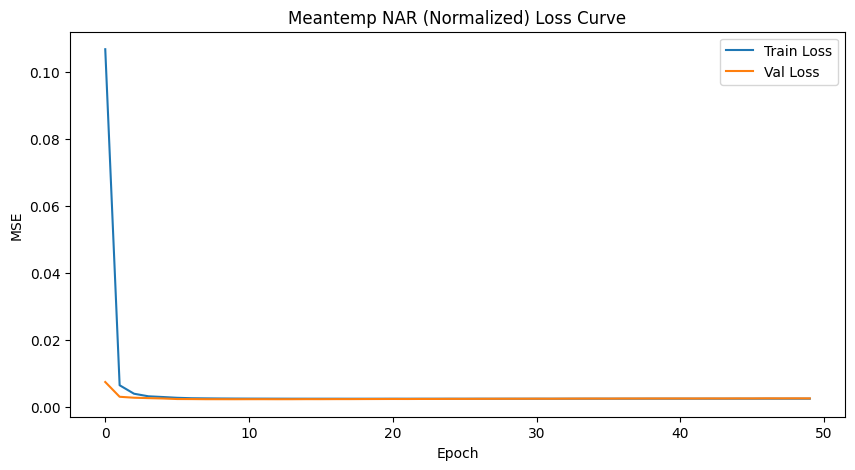

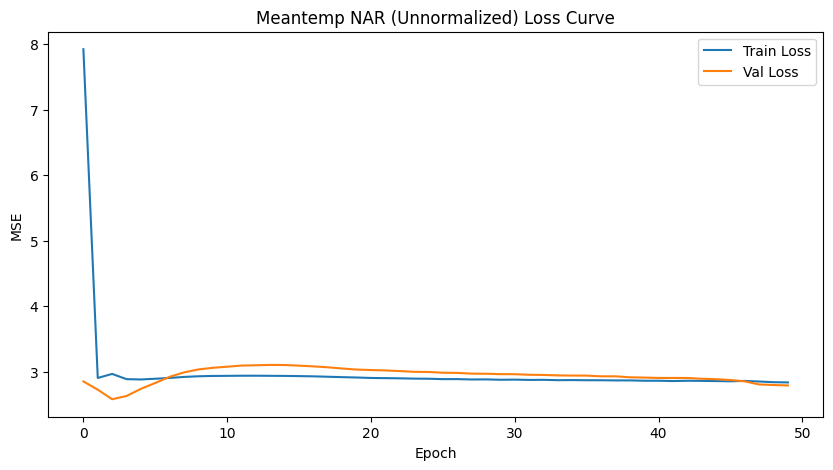

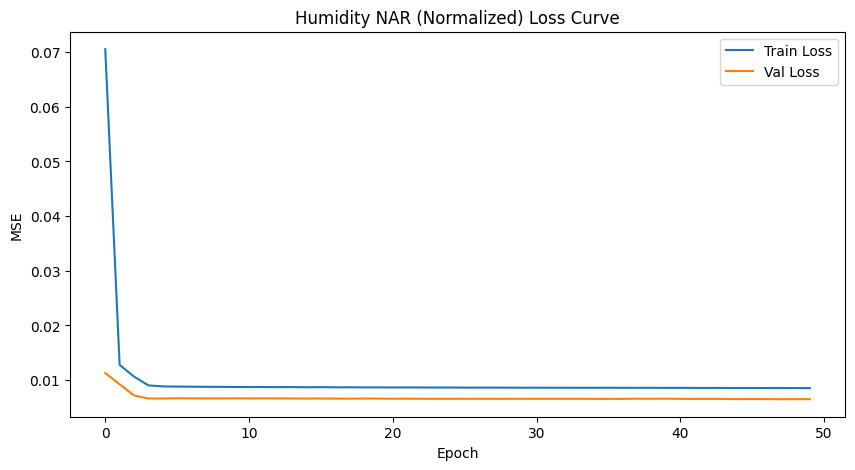

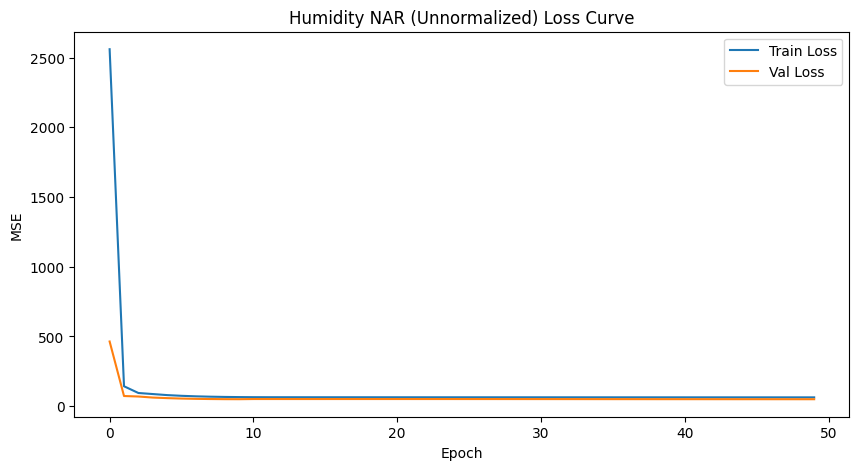

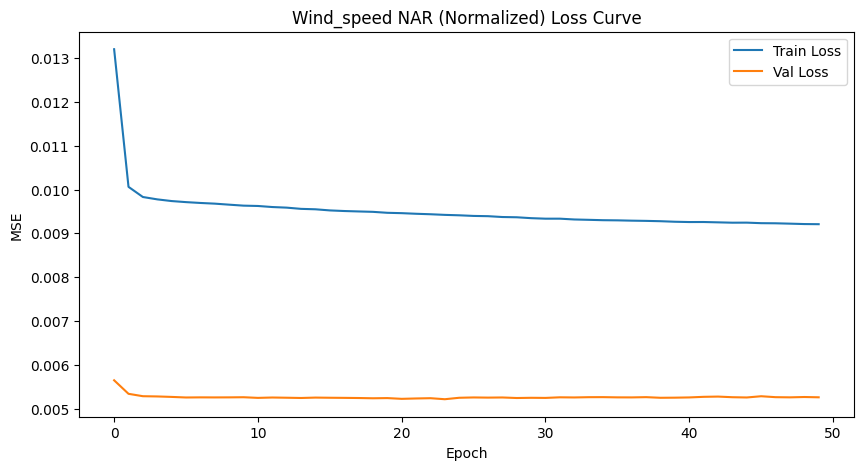

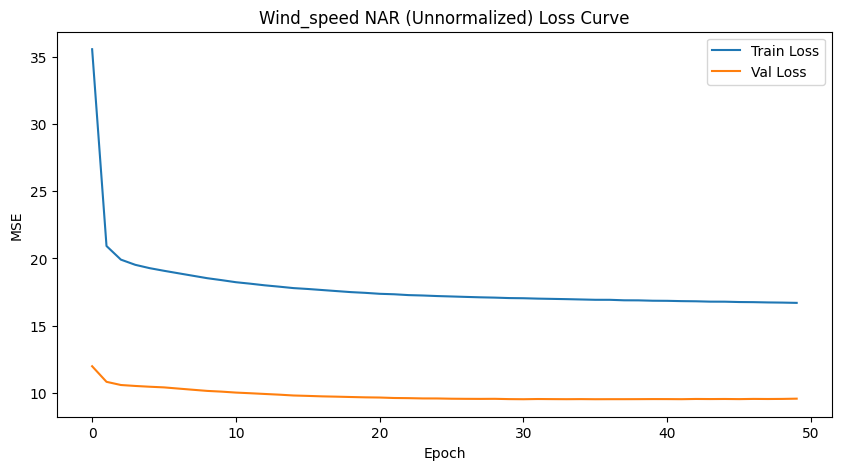

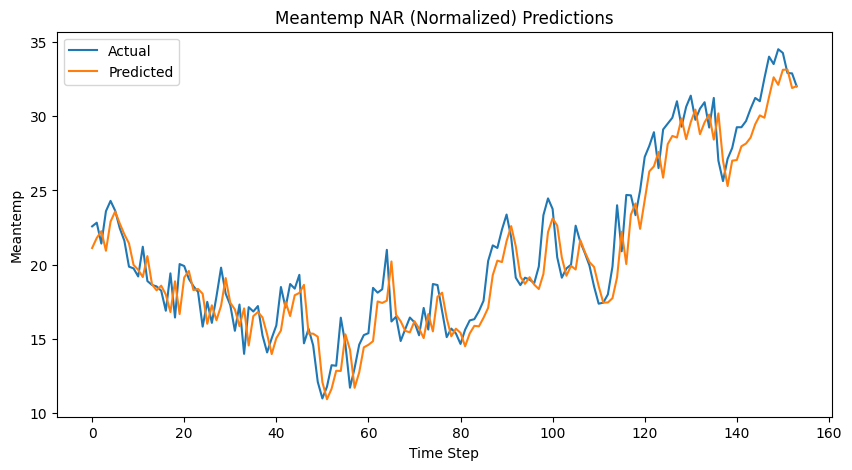

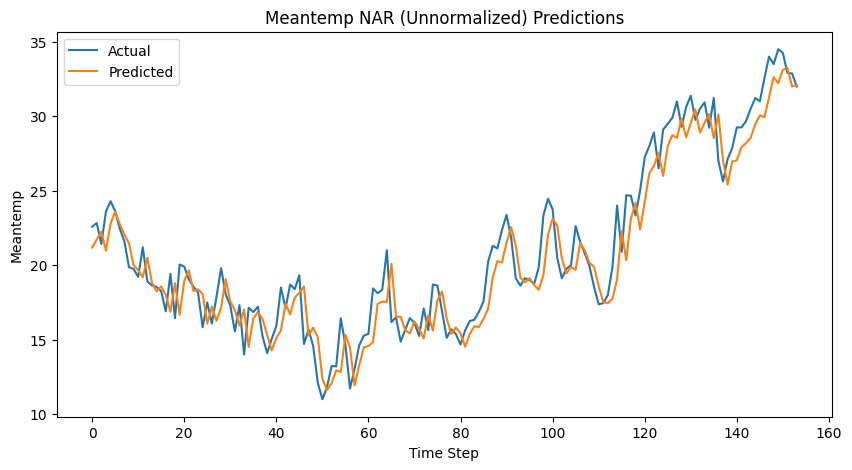

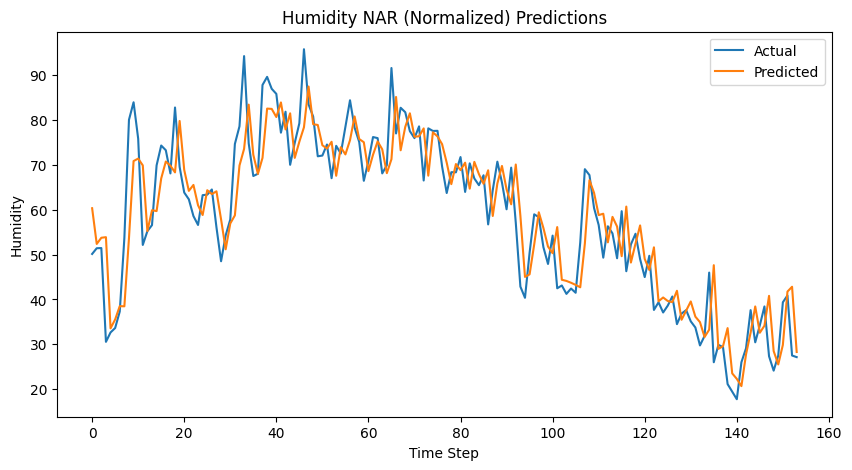

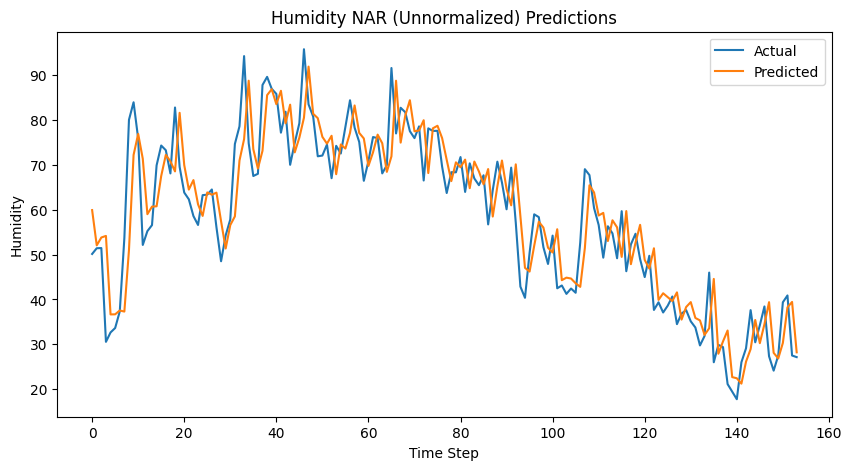

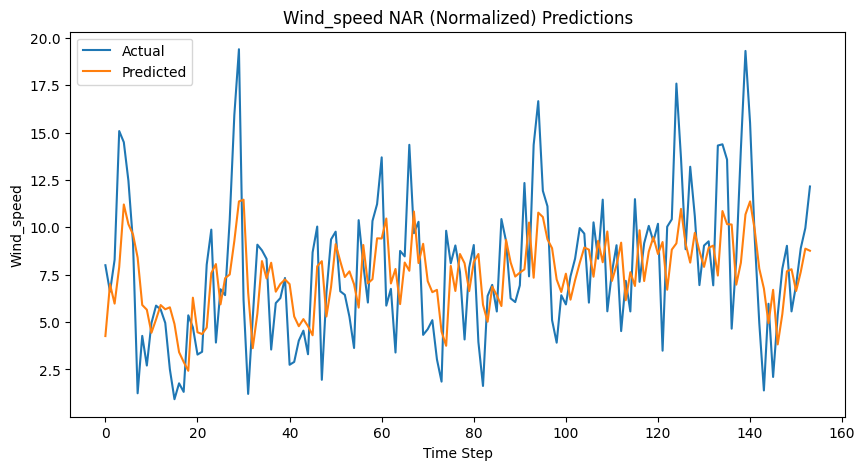

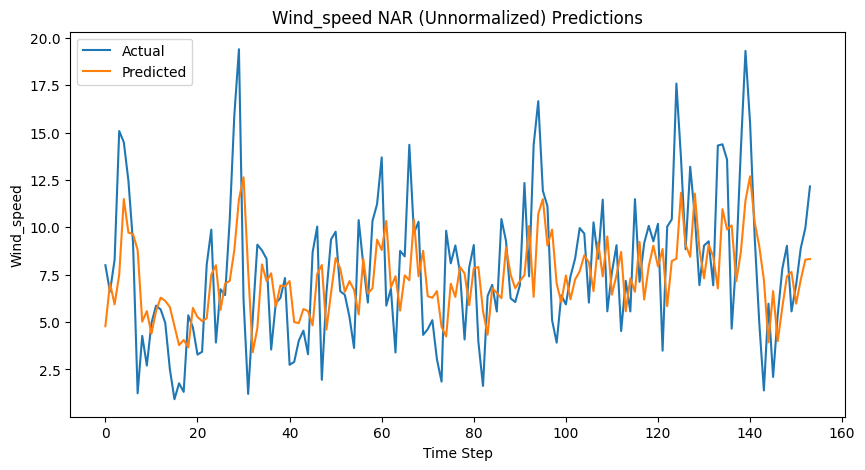

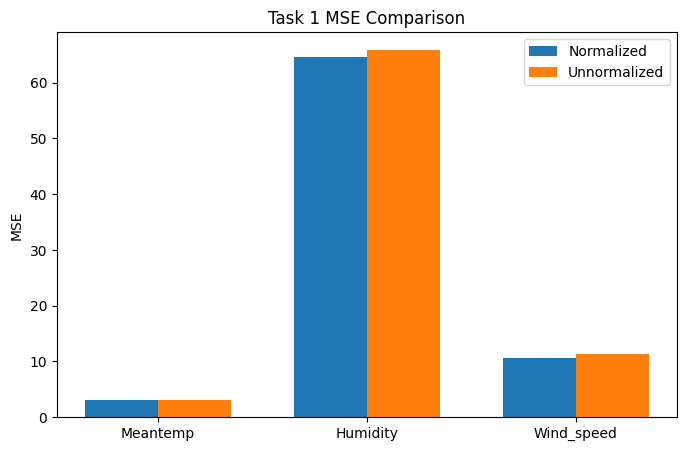


Comparative Analysis (Task 2):
Temperature NAR Normalized MSE: 3.1257
Temperature NARX Normalized MSE: 2.9085
Temperature NAR Unnormalized MSE: 3.1021
Temperature NARX Unnormalized MSE: 3.1624


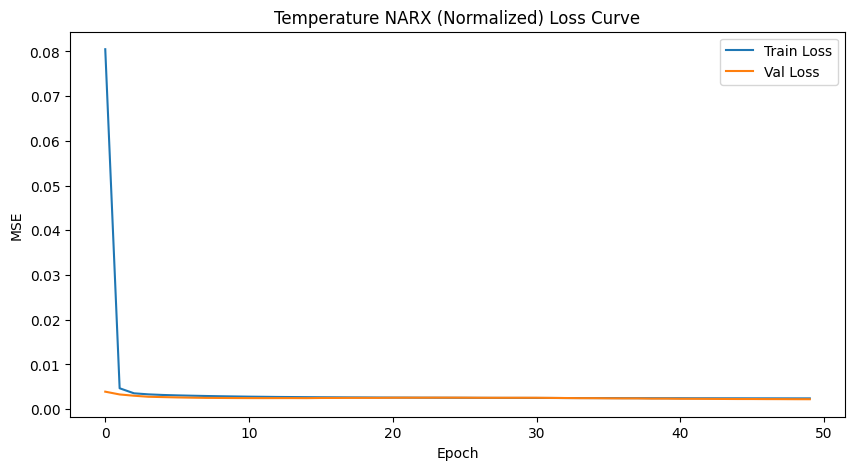

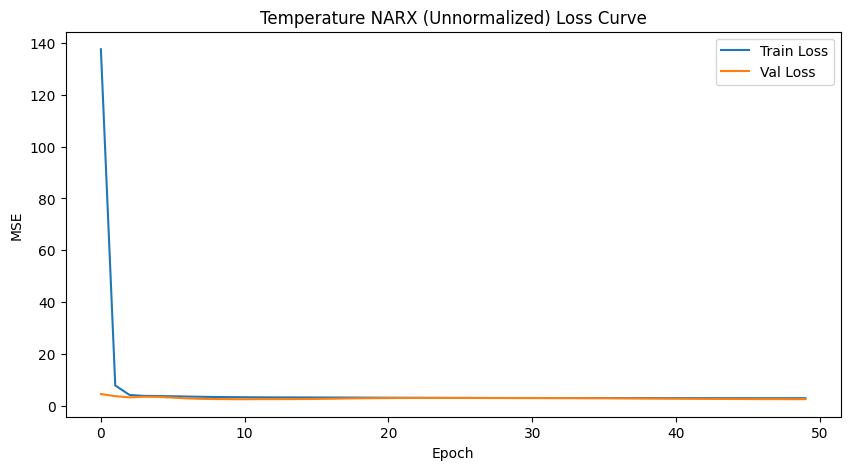

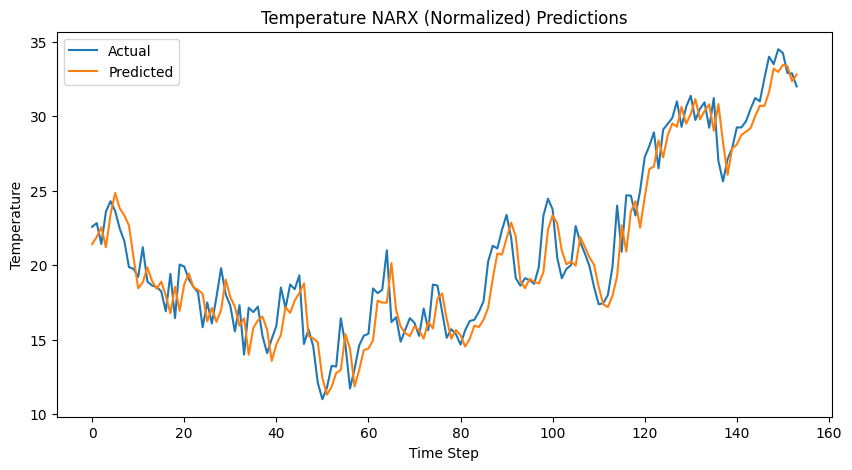

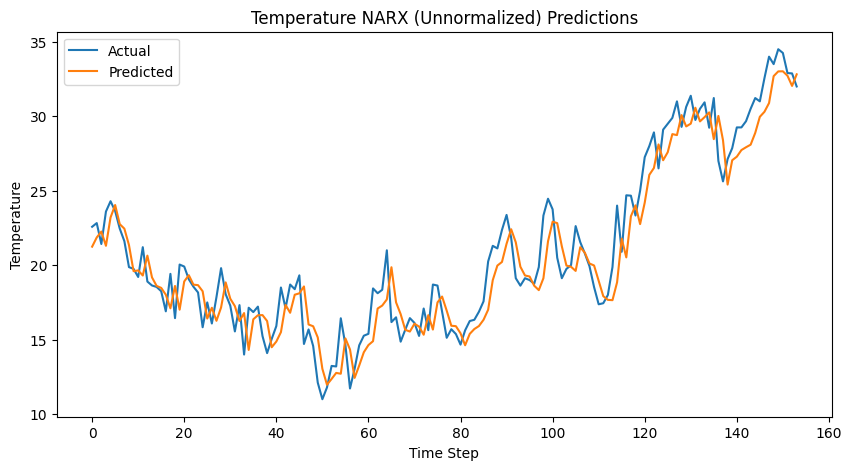

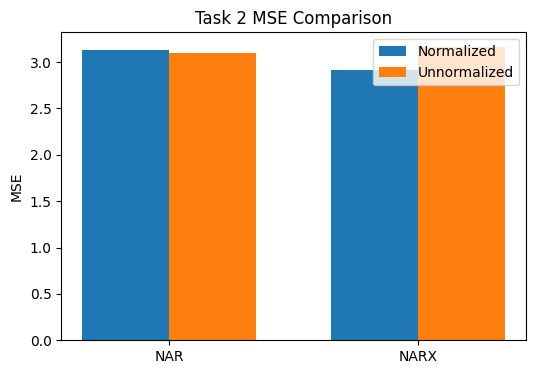


Task 3: Effect of Lag Size on NAR Model (Temperature)
Lag 2 - Test MSE: 2.6846
Lag 4 - Test MSE: 3.1746
Lag 6 - Test MSE: 2.9721
Lag 8 - Test MSE: 2.7672
Lag 10 - Test MSE: 3.7240


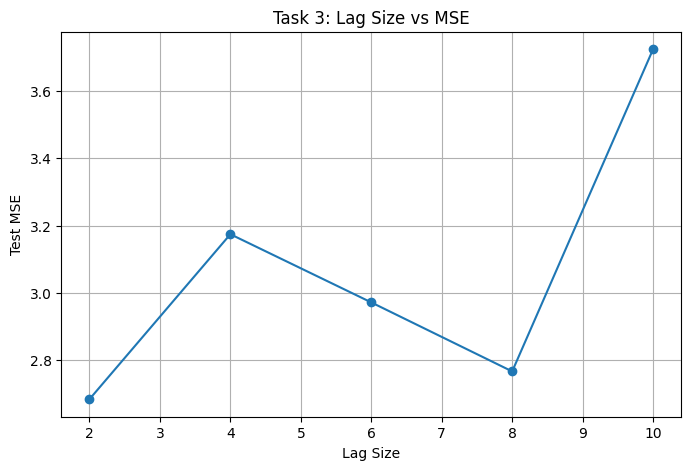

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
import random


class ClimateDataset:

    def __init__(self, filepath, date_col='date'):
        random.seed(42)
        np.random.seed(42)
        tf.random.set_seed(42)
        self.df = pd.read_csv('/content/DailyClimate (2).csv')
        self._prepare(date_col)

    def _prepare(self, date_col):
        self.df[date_col] = pd.to_datetime(self.df[date_col], format='%m/%d/%Y')
        self.df.set_index(date_col, inplace=True)
        self.df['meanpressure'] = (
            self.df['meanpressure']
            .where((self.df['meanpressure'] >= 900) & (self.df['meanpressure'] <= 1100))
            .interpolate(method='linear')
        )

    def split(self, train_frac=0.8, val_frac=0.1):
        total = len(self.df)
        train_end = int(total * train_frac)
        val_end = train_end + int(total * val_frac)
        self.train = self.df.iloc[:train_end].copy()
        self.val = self.df.iloc[train_end:val_end].copy()
        self.test = self.df.iloc[val_end:].copy()

    def scale(self, features):
        self.scalers = {f: MinMaxScaler() for f in features}
        for f in features:
            self.scalers[f].fit(self.train[[f]])
            for part in ['train', 'val', 'test']:
                df_part = getattr(self, part)
                df_part[f + '_scaled'] = self.scalers[f].transform(df_part[[f]])

class SequenceGenerator:
    @staticmethod
    def create_nar(series, lag):
        arr = series.values if hasattr(series, 'values') else np.array(series)
        X, y = [], []
        for i in range(lag, len(arr)):
            X.append(arr[i-lag:i])
            y.append(arr[i])
        return np.array(X), np.array(y)

    @staticmethod
    def create_narx(temp_series, hum_series, lag):
        arr_temp = temp_series.values if hasattr(temp_series, 'values') else np.array(temp_series)
        arr_hum = hum_series.values if hasattr(hum_series, 'values') else np.array(hum_series)
        X, y = [], []
        for i in range(lag, len(arr_temp)):
            X.append(np.concatenate([arr_temp[i-lag:i], arr_hum[i-lag:i]]))
            y.append(arr_temp[i])
        return np.array(X), np.array(y)

class NeuralNetModel:
    def __init__(self, input_dim):
        self.model = Sequential()
        self.model.add(Input(shape=(input_dim,)))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        self.model.compile(optimizer='adam', loss='mse')

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, verbose=0):
        return self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose
        )

    def predict(self, X):
        return self.model.predict(X, verbose=0)

class ClimatePredictor:
    def __init__(self, dataset: ClimateDataset, lag=4):
        self.data = dataset
        self.lag = lag
        self.results = {
            'normalized': {},
            'unnormalized': {},
            'narx': {},
            'narx_unnorm': {}
        }

    @staticmethod
    def inverse_transform(scaler, data):
        return scaler.inverse_transform(data.reshape(-1,1)).flatten()

    @staticmethod
    def calculate_mse(y_true, y_pred):
        return np.mean((y_true - y_pred)**2)

    def train_nar(self, feature, normalized=True):
        suffix = '_scaled' if normalized else ''
        X_tr, y_tr = SequenceGenerator.create_nar(self.data.train[feature+suffix], self.lag)
        X_val, y_val = SequenceGenerator.create_nar(self.data.val[feature+suffix], self.lag)
        X_te, y_te = SequenceGenerator.create_nar(self.data.test[feature+suffix], self.lag)

        model = NeuralNetModel(self.lag)
        history = model.train(X_tr, y_tr, X_val, y_val)
        y_pred = model.predict(X_te)

        if normalized:
            y_te_o = self.inverse_transform(self.data.scalers[feature], y_te)
            y_pred_o = self.inverse_transform(self.data.scalers[feature], y_pred)
            res = self.results['normalized']
        else:
            y_te_o, y_pred_o = y_te, y_pred.flatten()
            res = self.results['unnormalized']

        mse = self.calculate_mse(y_te_o, y_pred_o)
        res[feature] = {'mse': mse, 'y_test': y_te_o, 'y_pred': y_pred_o, 'history': history}
        return mse

    def train_narx(self, normalized=True):
        suffix = '_scaled' if normalized else ''
        temp_tr = self.data.train['meantemp'+suffix].values
        hum_tr = self.data.train['humidity'+suffix].values
        X_tr, y_tr = SequenceGenerator.create_narx(temp_tr, hum_tr, self.lag)
        temp_val = self.data.val['meantemp'+suffix].values
        hum_val = self.data.val['humidity'+suffix].values
        X_val, y_val = SequenceGenerator.create_narx(temp_val, hum_val, self.lag)
        temp_te = self.data.test['meantemp'+suffix].values
        hum_te = self.data.test['humidity'+suffix].values
        X_te, y_te = SequenceGenerator.create_narx(temp_te, hum_te, self.lag)

        model = NeuralNetModel(2*self.lag)
        history = model.train(X_tr, y_tr, X_val, y_val)
        y_pred = model.predict(X_te)

        if normalized:
            y_te_o = self.inverse_transform(self.data.scalers['meantemp'], y_te)
            y_pred_o = self.inverse_transform(self.data.scalers['meantemp'], y_pred)
            res = self.results['narx']
        else:
            y_te_o, y_pred_o = y_te, y_pred.flatten()
            res = self.results['narx_unnorm']

        mse = self.calculate_mse(y_te_o, y_pred_o)
        res['mse'] = mse
        res['y_test'] = y_te_o
        res['y_pred'] = y_pred_o
        res['history'] = history
        return mse

    def lag_experiment(self, lags):
        mse_lags = {}
        for lag in lags:
            self.lag = lag
            mse_lags[lag] = self.train_nar('meantemp', normalized=True)
        return mse_lags

if __name__ == '__main__':
    # Load and prepare data
    dataset = ClimateDataset('DailyClimate.csv')
    dataset.split()
    dataset.scale(['meantemp','humidity','wind_speed'])

    predictor = ClimatePredictor(dataset, lag=4)

    # Task 1: Run and collect MSEs
    features = ['meantemp','humidity','wind_speed']
    norm_mse = {}
    unnorm_mse = {}
    for f in features:
        norm_mse[f] = predictor.train_nar(f, normalized=True)
        unnorm_mse[f] = predictor.train_nar(f, normalized=False)

    # Comparative Analysis Task 1
    print("Comparative Analysis (Task 1):")
    for f in features:
        print(f"{f.capitalize()} - Normalized MSE: {norm_mse[f]:.4f}, Unnormalized MSE: {unnorm_mse[f]:.4f}")

    # Plot loss curves for Task 1
    for f in features:
        for norm_flag, label in [(True, 'Normalized'), (False, 'Unnormalized')]:
            key = 'normalized' if norm_flag else 'unnormalized'
            history = predictor.results[key][f]['history']
            plt.figure(figsize=(10,5))
            plt.plot(history.history['loss'], label='Train Loss')
            plt.plot(history.history['val_loss'], label='Val Loss')
            plt.title(f"{f.capitalize()} NAR ({label}) Loss Curve")
            plt.xlabel('Epoch')
            plt.ylabel('MSE')
            plt.legend()
            plt.show()

    # Plot predictions for Task 1
    for f in features:
        for norm_flag, label in [(True, 'Normalized'), (False, 'Unnormalized')]:
            key = 'normalized' if norm_flag else 'unnormalized'
            y_test = predictor.results[key][f]['y_test']
            y_pred = predictor.results[key][f]['y_pred']
            plt.figure(figsize=(10,5))
            plt.plot(y_test, label='Actual')
            plt.plot(y_pred, label='Predicted')
            plt.title(f"{f.capitalize()} NAR ({label}) Predictions")
            plt.xlabel('Time Step')
            plt.ylabel(f.capitalize())
            plt.legend()
            plt.show()

    # Plot MSE bar chart for Task 1
    x = np.arange(len(features))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x - width/2, [norm_mse[f] for f in features], width, label='Normalized')
    ax.bar(x + width/2, [unnorm_mse[f] for f in features], width, label='Unnormalized')
    ax.set_xticks(x)
    ax.set_xticklabels([f.capitalize() for f in features])
    ax.set_ylabel('MSE')
    ax.set_title('Task 1 MSE Comparison')
    ax.legend()
    plt.show()

    # Task 2: NAR vs NARX for Temperature
    nar_norm = norm_mse['meantemp']
    nar_unnorm = unnorm_mse['meantemp']
    narx_norm = predictor.train_narx(normalized=True)
    narx_unnorm = predictor.train_narx(normalized=False)

    print("\nComparative Analysis (Task 2):")
    print(f"Temperature NAR Normalized MSE: {nar_norm:.4f}")
    print(f"Temperature NARX Normalized MSE: {narx_norm:.4f}")
    print(f"Temperature NAR Unnormalized MSE: {nar_unnorm:.4f}")
    print(f"Temperature NARX Unnormalized MSE: {narx_unnorm:.4f}")

    # Plot loss curves for Task 2
    for norm_flag, label in [(True,'Normalized'),(False,'Unnormalized')]:
        key = 'narx' if norm_flag else 'narx_unnorm'
        history = predictor.results[key]['history']
        plt.figure(figsize=(10,5))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Temperature NARX ({label}) Loss Curve")
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend()
        plt.show()

    # Plot predictions for Task 2
    for norm_flag, label in [(True,'Normalized'),(False,'Unnormalized')]:
        key = 'narx' if norm_flag else 'narx_unnorm'
        y_test = predictor.results[key]['y_test']
        y_pred = predictor.results[key]['y_pred']
        plt.figure(figsize=(10,5))
        plt.plot(y_test, label='Actual')
        plt.plot(y_pred, label='Predicted')
        plt.title(f"Temperature NARX ({label}) Predictions")
        plt.xlabel('Time Step')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    # Plot MSE bar chart for Task 2
    labels = ['NAR','NARX']
    norm_vals = [nar_norm, narx_norm]
    unnorm_vals = [nar_unnorm, narx_unnorm]
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(x - width/2, norm_vals, width, label='Normalized')
    ax.bar(x + width/2, unnorm_vals, width, label='Unnormalized')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('MSE')
    ax.set_title('Task 2 MSE Comparison')
    ax.legend()
    plt.show()

    # Task 3: Lag experiment
    print("\nTask 3: Effect of Lag Size on NAR Model (Temperature)")
    lags = [2,4,6,8,10]
    lag_mse = predictor.lag_experiment(lags)
    for lag, mse in lag_mse.items():
        print(f"Lag {lag} - Test MSE: {mse:.4f}")

    # Plot MSE vs Lag for Task 3
    plt.figure(figsize=(8,5))
    plt.plot(list(lag_mse.keys()), list(lag_mse.values()), marker='o')
    plt.title('Task 3: Lag Size vs MSE')
    plt.xlabel('Lag Size')
    plt.ylabel('Test MSE')
    plt.grid(True)
    plt.show()


Comparative Analysis Task 1:
Meantemp -> Norm MSE: 2.7485, Unnorm MSE: 2.8212
Humidity -> Norm MSE: 66.0224, Unnorm MSE: 64.7329
Wind_speed -> Norm MSE: 10.7170, Unnorm MSE: 11.1412


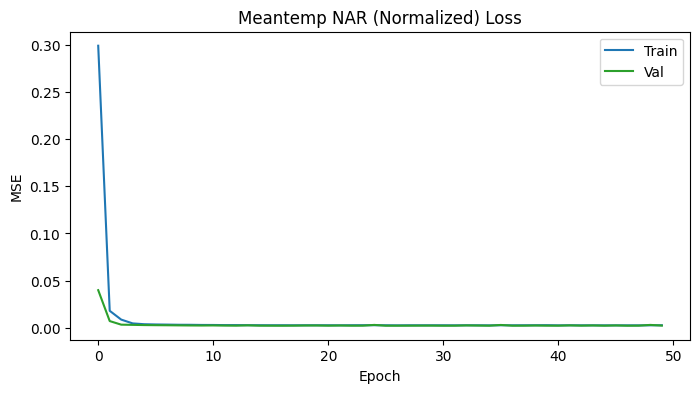

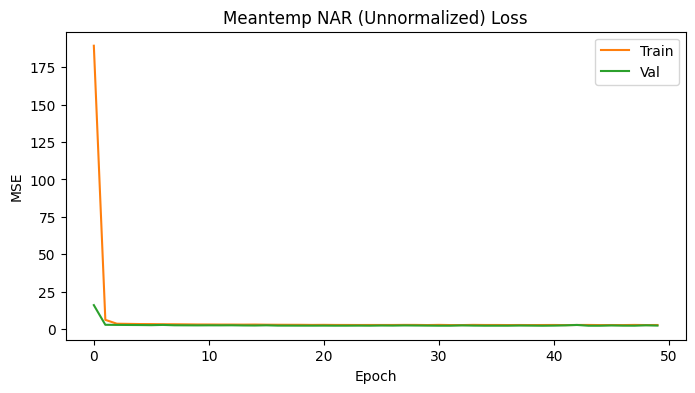

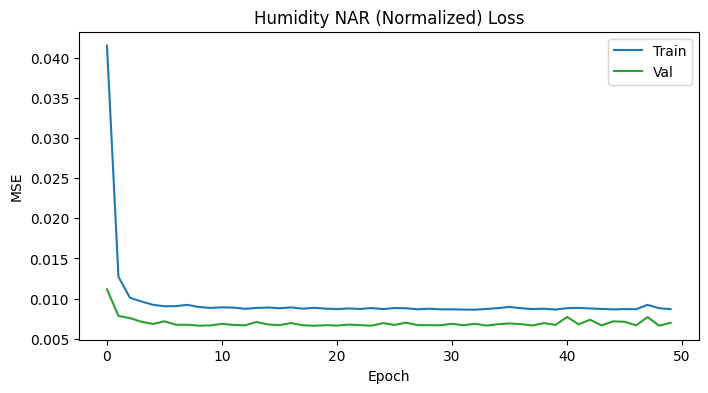

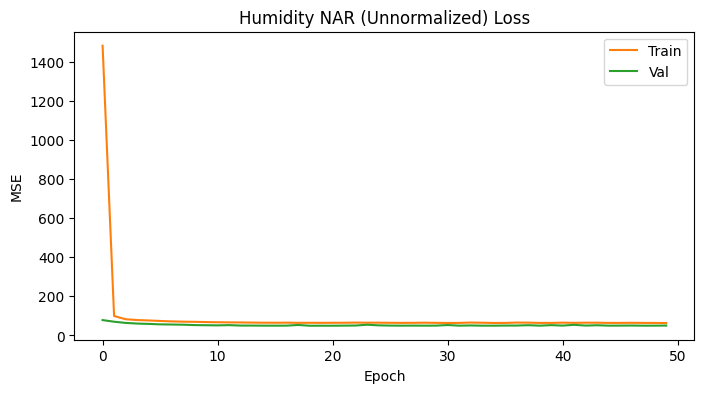

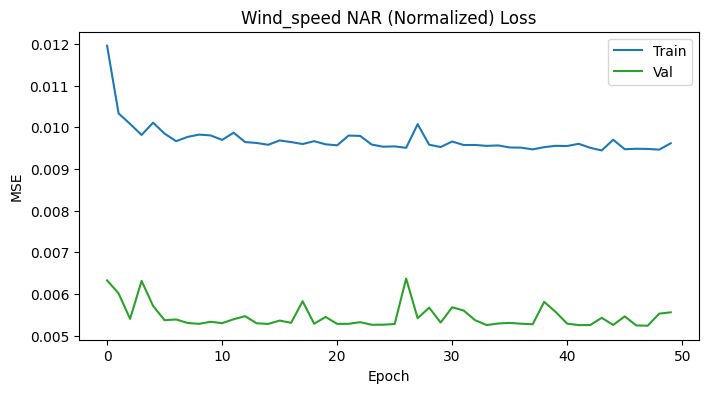

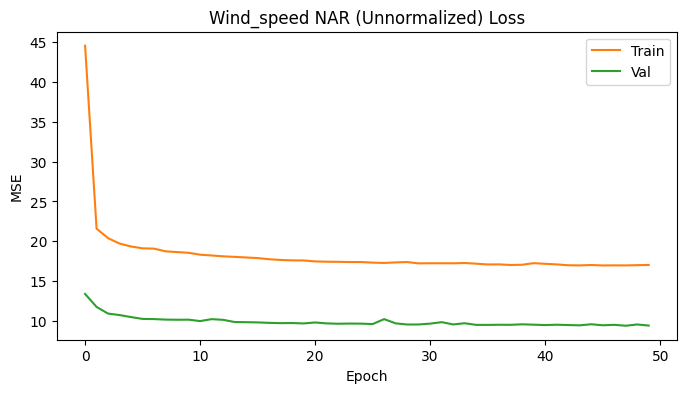

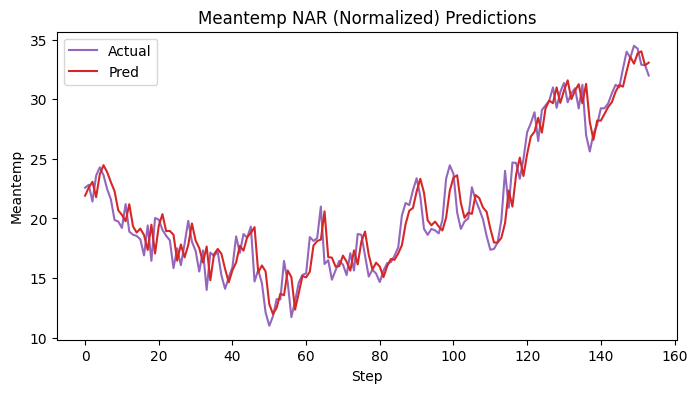

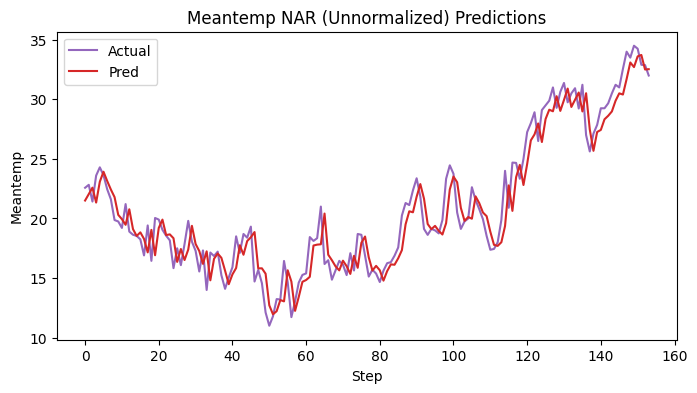

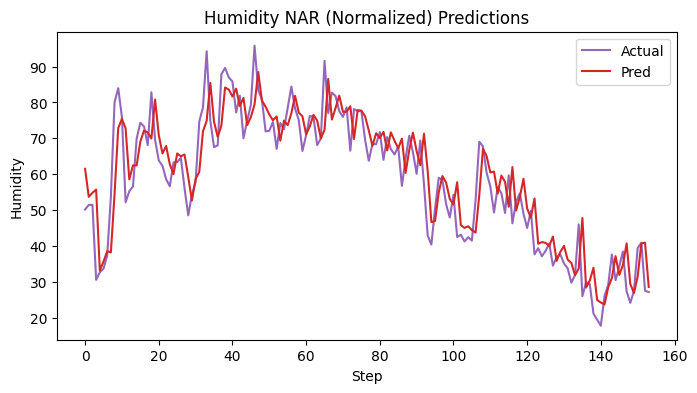

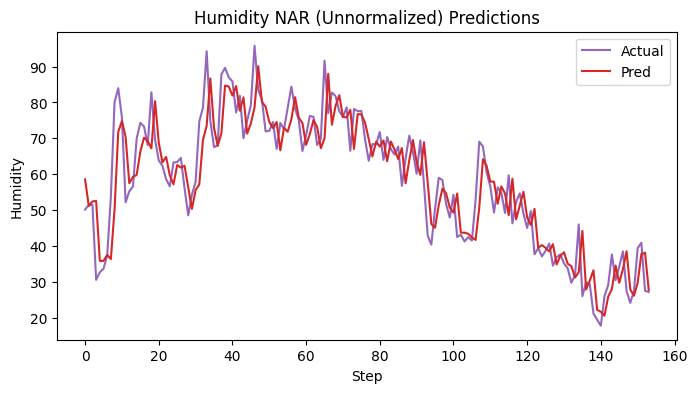

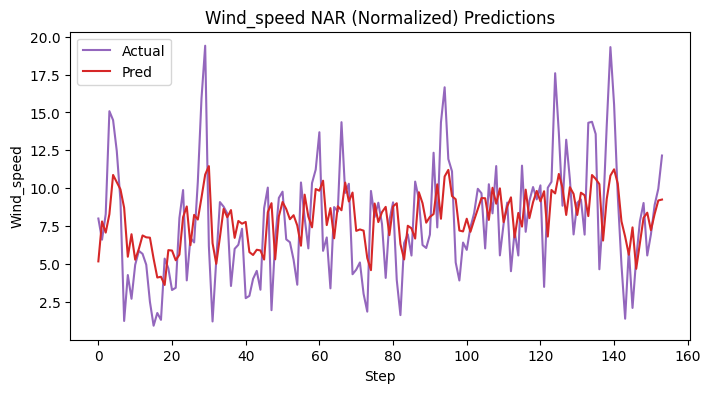

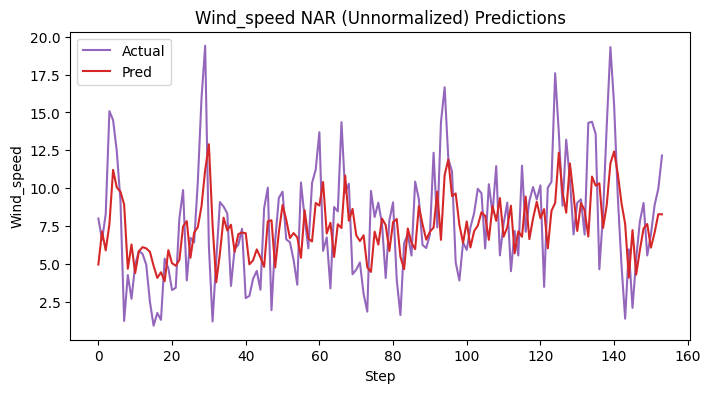


Task 2: NAR Norm 2.7485, NARX Norm 2.7681
Task 2: NAR Unnorm 2.8212, NARX Unnorm 3.4110

Task 3 Lag Study:
Lag 2: MSE 2.8412
Lag 4: MSE 2.7727
Lag 6: MSE 2.7299
Lag 8: MSE 2.9150
Lag 10: MSE 2.7994


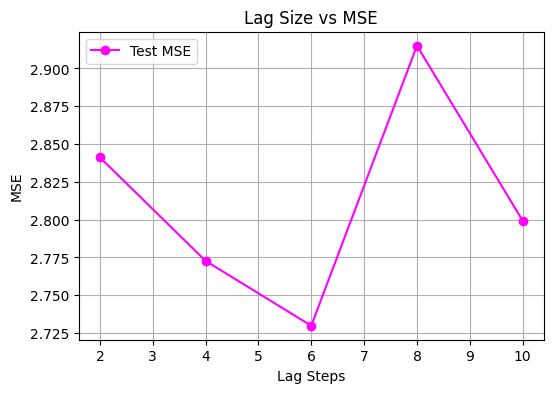

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DataProcessor:
    def __init__(self, path, date_column='date'):
        self.dataframe = pd.read_csv(path)
        self._prepare_dates(date_column)

    def _prepare_dates(self, col):
        self.dataframe[col] = pd.to_datetime(self.dataframe[col], format='%m/%d/%Y')
        self.dataframe.set_index(col, inplace=True)
        # Interpolate pressure outliers
        self.dataframe['meanpressure'] = (
            self.dataframe['meanpressure']
                .where((self.dataframe['meanpressure'] >= 900) & (self.dataframe['meanpressure'] <= 1100))
                .interpolate()
        )

    def split_data(self, train_ratio=0.8, val_ratio=0.1):
        n = len(self.dataframe)
        train_end = int(n * train_ratio)
        val_end = train_end + int(n * val_ratio)
        self.train_df = self.dataframe.iloc[:train_end].copy()
        self.val_df   = self.dataframe.iloc[train_end:val_end].copy()
        self.test_df  = self.dataframe.iloc[val_end:].copy()

    def apply_scaling(self, cols):
        self.scaler_map = {c: MinMaxScaler() for c in cols}
        for c in cols:
            self.scaler_map[c].fit(self.train_df[[c]])
            for subset in ('train_df', 'val_df', 'test_df'):
                df_part = getattr(self, subset)
                df_part[c + '_scaled'] = self.scaler_map[c].transform(df_part[[c]])

class SequenceCreator:
    @staticmethod
    def create_nar(series, lag):
        arr = series.to_numpy()
        X, y = [], []
        for i in range(lag, len(arr)):
            X.append(arr[i-lag:i])
            y.append(arr[i])
        return np.array(X), np.array(y)

    @staticmethod
    def create_narx(series_x, series_exog, lag):
        x = series_x.to_numpy()
        exog = series_exog.to_numpy()
        X, y = [], []
        for i in range(lag, len(x)):
            X.append(np.concatenate([x[i-lag:i], exog[i-lag:i]]))
            y.append(x[i])
        return np.array(X), np.array(y)

class PyTorchRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class Forecaster:
    def __init__(self, processor: DataProcessor, lag_steps=4):
        self.processor = processor
        self.lag_steps = lag_steps
        self.history = {}
        self.metrics = {}

    @staticmethod
    def _to_tensor(x):
        return torch.tensor(x, dtype=torch.float32, device=device)

    def _train_loop(self, model, X_tr, y_tr, X_va, y_va, epochs=50, batch=32):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_losses, val_losses = [], []
        model.to(device)
        for _ in range(epochs):
            model.train()
            perm = np.random.permutation(len(X_tr))
            X_sh, y_sh = X_tr[perm], y_tr[perm]
            epoch_loss = 0
            for i in range(0, len(X_sh), batch):
                xb = self._to_tensor(X_sh[i:i+batch])
                yb = self._to_tensor(y_sh[i:i+batch]).unsqueeze(1)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * xb.size(0)
            train_losses.append(epoch_loss / len(X_tr))
            model.eval()
            with torch.no_grad():
                xb = self._to_tensor(X_va)
                yb = self._to_tensor(y_va).unsqueeze(1)
                val_losses.append(criterion(model(xb), yb).item())
        return {'train_loss': train_losses, 'val_loss': val_losses}

    def fit_nar(self, col, normalize=True):
        suf = '_scaled' if normalize else ''
        tr, va, te = self.processor.train_df, self.processor.val_df, self.processor.test_df
        X_tr, y_tr = SequenceCreator.create_nar(tr[col + suf], self.lag_steps)
        X_va, y_va = SequenceCreator.create_nar(va[col + suf], self.lag_steps)
        X_te, y_te = SequenceCreator.create_nar(te[col + suf], self.lag_steps)

        model = PyTorchRegressor(self.lag_steps)
        hist = self._train_loop(model, X_tr, y_tr, X_va, y_va)
        model.eval()
        with torch.no_grad():
            preds = model(self._to_tensor(X_te)).cpu().numpy().flatten()
        actual = y_te.copy()
        if normalize:
            actual = self.processor.scaler_map[col].inverse_transform(actual.reshape(-1,1)).flatten()
            preds  = self.processor.scaler_map[col].inverse_transform(preds.reshape(-1,1)).flatten()
            key = f"nar_norm_{col}"
        else:
            key = f"nar_unnorm_{col}"
        mse = np.mean((actual - preds)**2)
        self.history[key], self.metrics[key] = hist, {'mse': mse, 'actual': actual, 'preds': preds}
        return mse

    def fit_narx(self, normalize=True):
        suf = '_scaled' if normalize else ''
        tr, va, te = self.processor.train_df, self.processor.val_df, self.processor.test_df
        X_tr, y_tr = SequenceCreator.create_narx(tr['meantemp'+suf], tr['humidity'+suf], self.lag_steps)
        X_va, y_va = SequenceCreator.create_narx(va['meantemp'+suf], va['humidity'+suf], self.lag_steps)
        X_te, y_te = SequenceCreator.create_narx(te['meantemp'+suf], te['humidity'+suf], self.lag_steps)

        model = PyTorchRegressor(2*self.lag_steps)
        hist = self._train_loop(model, X_tr, y_tr, X_va, y_va)
        model.eval()
        with torch.no_grad():
            preds = model(self._to_tensor(X_te)).cpu().numpy().flatten()
        actual = y_te.copy()
        if normalize:
            actual = self.processor.scaler_map['meantemp'].inverse_transform(actual.reshape(-1,1)).flatten()
            preds  = self.processor.scaler_map['meantemp'].inverse_transform(preds.reshape(-1,1)).flatten()
            key = 'narx_norm'
        else:
            key = 'narx_unnorm'
        mse = np.mean((actual - preds)**2)
        self.history[key], self.metrics[key] = hist, {'mse': mse, 'actual': actual, 'preds': preds}
        return mse

    def lag_study(self, lags):
        return {L: self.fit_nar('meantemp', normalize=True) for L in lags}

if __name__ == '__main__':
    proc = DataProcessor('DailyClimate (2).csv')
    proc.split_data()
    proc.apply_scaling(['meantemp','humidity','wind_speed'])

    fore = Forecaster(proc, lag_steps=4)
    features = ['meantemp','humidity','wind_speed']
    mse_norm = {f: fore.fit_nar(f, True) for f in features}
    mse_unnorm = {f: fore.fit_nar(f, False) for f in features}

    print("Comparative Analysis Task 1:")
    for f in features:
        print(f"{f.capitalize()} -> Norm MSE: {mse_norm[f]:.4f}, Unnorm MSE: {mse_unnorm[f]:.4f}")

    for f in features:
        for norm_flag,lbl,col in [(True,'Normalized','tab:blue'),(False,'Unnormalized','tab:orange')]:
            key = f"nar_{'norm' if norm_flag else 'unnorm'}_{f}"
            h = fore.history[key]
            plt.figure(figsize=(8,4))
            plt.plot(h['train_loss'],label='Train',color=col)
            plt.plot(h['val_loss'],label='Val',  color='tab:green')
            plt.title(f"{f.capitalize()} NAR ({lbl}) Loss")
            plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

    for f in features:
        for norm_flag,lbl in [(True,'Normalized'),(False,'Unnormalized')]:
            key = f"nar_{'norm' if norm_flag else 'unnorm'}_{f}"
            act=fore.metrics[key]['actual']; pred=fore.metrics[key]['preds']
            plt.figure(figsize=(8,4))
            plt.plot(act,label='Actual',   color='tab:purple')
            plt.plot(pred,label='Pred', color='tab:red')
            plt.title(f"{f.capitalize()} NAR ({lbl}) Predictions")
            plt.xlabel('Step'); plt.ylabel(f.capitalize()); plt.legend(); plt.show()



    nar_n=mse_norm['meantemp']; narx_n=fore.fit_narx(True)
    nar_u=mse_unnorm['meantemp']; narx_u=fore.fit_narx(False)
    print(f"\nTask 2: NAR Norm {nar_n:.4f}, NARX Norm {narx_n:.4f}\nTask 2: NAR Unnorm {nar_u:.4f}, NARX Unnorm {narx_u:.4f}")



    lags=[2,4,6,8,10]; lag_res=fore.lag_study(lags)
    print("\nTask 3 Lag Study:")
    for L,m in lag_res.items(): print(f"Lag {L}: MSE {m:.4f}")

    plt.figure(figsize=(6,4))
plt.plot(list(lag_res.keys()), list(lag_res.values()), marker='o', color='magenta', label='Test MSE')
plt.title('Lag Size vs MSE')
plt.xlabel('Lag Steps')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.show()


Comparative Analysis Task 1:
Meantemp -> Norm MSE: 2.7485, Unnorm MSE: 2.8212
Humidity -> Norm MSE: 66.0224, Unnorm MSE: 64.7329
Wind_speed -> Norm MSE: 10.7170, Unnorm MSE: 11.1412

Task 2:
  NAR Norm   MSE = 2.7485
  NARX Norm  MSE = 2.7681
  NAR Unnorm MSE = 2.8212
  NARX Unnorm MSE = 3.4110


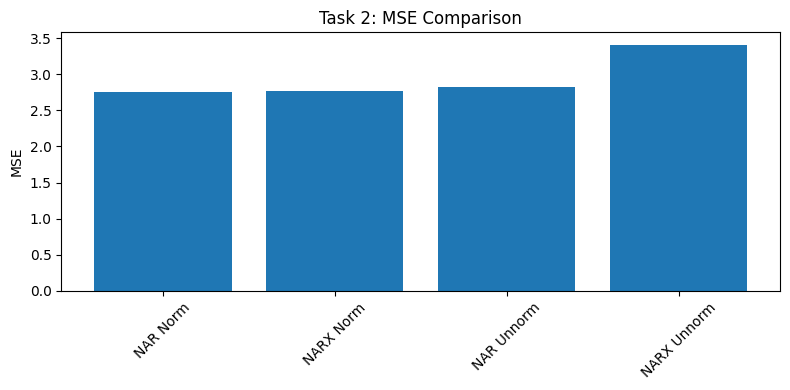

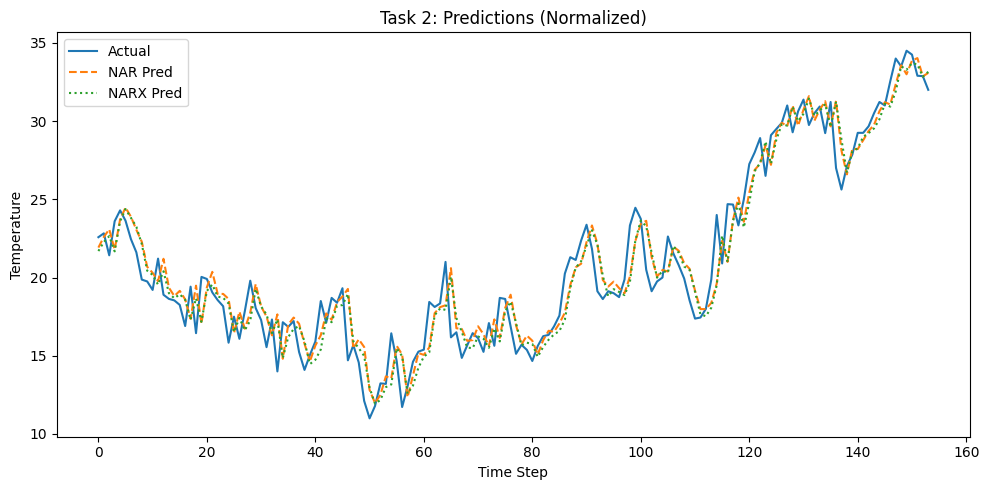

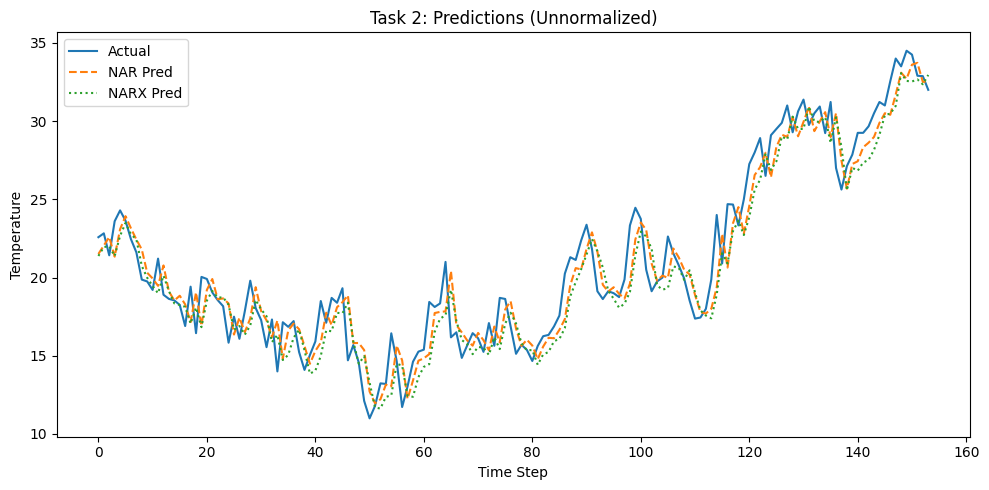


Task 3 Lag Study:
  Lag 2: MSE = 2.8412
  Lag 4: MSE = 2.7727
  Lag 6: MSE = 2.7299
  Lag 8: MSE = 2.9150
  Lag 10: MSE = 2.7994


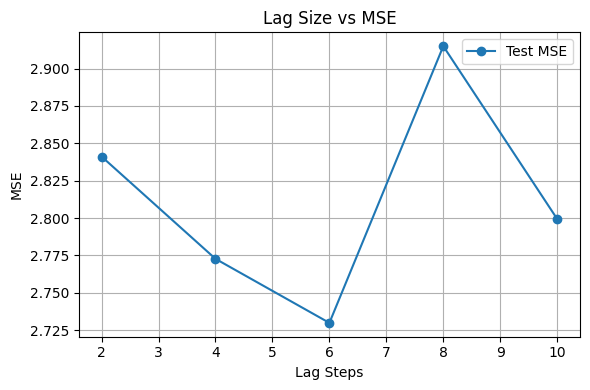

In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DataProcessor:
    def __init__(self, path, date_column='date'):
        self.dataframe = pd.read_csv(path)
        self._prepare_dates(date_column)

    def _prepare_dates(self, col):
        self.dataframe[col] = pd.to_datetime(self.dataframe[col], format='%m/%d/%Y')
        self.dataframe.set_index(col, inplace=True)
        # Interpolate pressure outliers
        self.dataframe['meanpressure'] = (
            self.dataframe['meanpressure']
                .where((self.dataframe['meanpressure'] >= 900) & (self.dataframe['meanpressure'] <= 1100))
                .interpolate()
        )

    def split_data(self, train_ratio=0.8, val_ratio=0.1):
        n = len(self.dataframe)
        train_end = int(n * train_ratio)
        val_end = train_end + int(n * val_ratio)
        self.train_df = self.dataframe.iloc[:train_end].copy()
        self.val_df   = self.dataframe.iloc[train_end:val_end].copy()
        self.test_df  = self.dataframe.iloc[val_end:].copy()

    def apply_scaling(self, cols):
        self.scaler_map = {c: MinMaxScaler() for c in cols}
        for c in cols:
            self.scaler_map[c].fit(self.train_df[[c]])
            for subset in ('train_df', 'val_df', 'test_df'):
                df_part = getattr(self, subset)
                df_part[c + '_scaled'] = self.scaler_map[c].transform(df_part[[c]])

class SequenceCreator:
    @staticmethod
    def create_nar(series, lag):
        arr = series.to_numpy()
        X, y = [], []
        for i in range(lag, len(arr)):
            X.append(arr[i-lag:i])
            y.append(arr[i])
        return np.array(X), np.array(y)

    @staticmethod
    def create_narx(series_x, series_exog, lag):
        x = series_x.to_numpy()
        exog = series_exog.to_numpy()
        X, y = [], []
        for i in range(lag, len(x)):
            X.append(np.concatenate([x[i-lag:i], exog[i-lag:i]]))
            y.append(x[i])
        return np.array(X), np.array(y)

class PyTorchRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class Forecaster:
    def __init__(self, processor: DataProcessor, lag_steps=4):
        self.processor = processor
        self.lag_steps = lag_steps
        self.history = {}
        self.metrics = {}

    @staticmethod
    def _to_tensor(x):
        return torch.tensor(x, dtype=torch.float32, device=device)

    def _train_loop(self, model, X_tr, y_tr, X_va, y_va, epochs=50, batch=32):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_losses, val_losses = [], []
        model.to(device)
        for _ in range(epochs):
            model.train()
            perm = np.random.permutation(len(X_tr))
            X_sh, y_sh = X_tr[perm], y_tr[perm]
            epoch_loss = 0
            for i in range(0, len(X_sh), batch):
                xb = self._to_tensor(X_sh[i:i+batch])
                yb = self._to_tensor(y_sh[i:i+batch]).unsqueeze(1)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * xb.size(0)
            train_losses.append(epoch_loss / len(X_tr))
            model.eval()
            with torch.no_grad():
                xb = self._to_tensor(X_va)
                yb = self._to_tensor(y_va).unsqueeze(1)
                val_losses.append(criterion(model(xb), yb).item())
        return {'train_loss': train_losses, 'val_loss': val_losses}

    def fit_nar(self, col, normalize=True):
        suf = '_scaled' if normalize else ''
        tr, va, te = self.processor.train_df, self.processor.val_df, self.processor.test_df
        X_tr, y_tr = SequenceCreator.create_nar(tr[col + suf], self.lag_steps)
        X_va, y_va = SequenceCreator.create_nar(va[col + suf], self.lag_steps)
        X_te, y_te = SequenceCreator.create_nar(te[col + suf], self.lag_steps)

        model = PyTorchRegressor(self.lag_steps)
        hist = self._train_loop(model, X_tr, y_tr, X_va, y_va)
        model.eval()
        with torch.no_grad():
            preds = model(self._to_tensor(X_te)).cpu().numpy().flatten()
        actual = y_te.copy()
        if normalize:
            actual = self.processor.scaler_map[col].inverse_transform(actual.reshape(-1,1)).flatten()
            preds  = self.processor.scaler_map[col].inverse_transform(preds.reshape(-1,1)).flatten()
            key = f"nar_norm_{col}"
        else:
            key = f"nar_unnorm_{col}"
        mse = np.mean((actual - preds)**2)
        self.history[key], self.metrics[key] = hist, {'mse': mse, 'actual': actual, 'preds': preds}
        return mse

    def fit_narx(self, normalize=True):
        suf = '_scaled' if normalize else ''
        tr, va, te = self.processor.train_df, self.processor.val_df, self.processor.test_df
        X_tr, y_tr = SequenceCreator.create_narx(tr['meantemp'+suf], tr['humidity'+suf], self.lag_steps)
        X_va, y_va = SequenceCreator.create_narx(va['meantemp'+suf], va['humidity'+suf], self.lag_steps)
        X_te, y_te = SequenceCreator.create_narx(te['meantemp'+suf], te['humidity'+suf], self.lag_steps)

        model = PyTorchRegressor(2*self.lag_steps)
        hist = self._train_loop(model, X_tr, y_tr, X_va, y_va)
        model.eval()
        with torch.no_grad():
            preds = model(self._to_tensor(X_te)).cpu().numpy().flatten()
        actual = y_te.copy()
        if normalize:
            actual = self.processor.scaler_map['meantemp'].inverse_transform(actual.reshape(-1,1)).flatten()
            preds  = self.processor.scaler_map['meantemp'].inverse_transform(preds.reshape(-1,1)).flatten()
            key = 'narx_norm'
        else:
            key = 'narx_unnorm'
        mse = np.mean((actual - preds)**2)
        self.history[key], self.metrics[key] = hist, {'mse': mse, 'actual': actual, 'preds': preds}
        return mse

    def lag_study(self, lags):
        return {L: self.fit_nar('meantemp', normalize=True) for L in lags}

if __name__ == '__main__':
    # 1. Load and preprocess
    proc = DataProcessor('DailyClimate (2).csv')
    proc.split_data()
    proc.apply_scaling(['meantemp','humidity','wind_speed'])

    # 2. Initialize forecaster
    fore = Forecaster(proc, lag_steps=4)
    features = ['meantemp','humidity','wind_speed']

    # 3. Task 1: NAR for each feature (normalized & unnormalized)
    mse_norm   = {f: fore.fit_nar(f, True)  for f in features}
    mse_unnorm = {f: fore.fit_nar(f, False) for f in features}

    print("Comparative Analysis Task 1:")
    for f in features:
        print(f"{f.capitalize()} -> Norm MSE: {mse_norm[f]:.4f}, Unnorm MSE: {mse_unnorm[f]:.4f}")

    # (Optional) Plot Task 1 results here...

    # 4. Task 2: NAR vs NARX for temperature
    nar_n  = mse_norm['meantemp']
    nar_u  = mse_unnorm['meantemp']
    narx_n = fore.fit_narx(True)
    narx_u = fore.fit_narx(False)

    print(f"\nTask 2:")
    print(f"  NAR Norm   MSE = {nar_n:.4f}")
    print(f"  NARX Norm  MSE = {narx_n:.4f}")
    print(f"  NAR Unnorm MSE = {nar_u:.4f}")
    print(f"  NARX Unnorm MSE = {narx_u:.4f}")

    # ==== Plot MSE comparison ====
    mse_values = [nar_n, narx_n, nar_u, narx_u]
    labels = ['NAR Norm', 'NARX Norm', 'NAR Unnorm', 'NARX Unnorm']

    plt.figure(figsize=(8, 4))
    plt.bar(labels, mse_values)
    plt.title('Task 2: MSE Comparison')
    plt.ylabel('MSE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ==== Plot predictions comparison (normalized) ====
    act_nar   = fore.metrics['nar_norm_meantemp']['actual']
    pred_nar  = fore.metrics['nar_norm_meantemp']['preds']
    act_narx  = fore.metrics['narx_norm']['actual']
    pred_narx = fore.metrics['narx_norm']['preds']

    plt.figure(figsize=(10, 5))
    plt.plot(act_nar,   label='Actual', linestyle='-')
    plt.plot(pred_nar,  label='NAR Pred', linestyle='--')
    plt.plot(pred_narx, label='NARX Pred', linestyle=':')
    plt.title('Task 2: Predictions (Normalized)')
    plt.xlabel('Time Step')
    plt.ylabel('Temperature')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ==== Plot predictions comparison (unnormalized) ====
    act_nar_u   = fore.metrics['nar_unnorm_meantemp']['actual']
    pred_nar_u  = fore.metrics['nar_unnorm_meantemp']['preds']
    act_narx_u  = fore.metrics['narx_unnorm']['actual']
    pred_narx_u = fore.metrics['narx_unnorm']['preds']

    plt.figure(figsize=(10, 5))
    plt.plot(act_nar_u,   label='Actual', linestyle='-')
    plt.plot(pred_nar_u,  label='NAR Pred', linestyle='--')
    plt.plot(pred_narx_u, label='NARX Pred', linestyle=':')
    plt.title('Task 2: Predictions (Unnormalized)')
    plt.xlabel('Time Step')
    plt.ylabel('Temperature')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5. Task 3: Lag study
    lags = [2, 4, 6, 8, 10]
    lag_res = fore.lag_study(lags)

    print("\nTask 3 Lag Study:")
    for L, mse_val in lag_res.items():
        print(f"  Lag {L}: MSE = {mse_val:.4f}")

    # Plot lag vs MSE
    plt.figure(figsize=(6,4))
    plt.plot(list(lag_res.keys()), list(lag_res.values()), marker='o', label='Test MSE')
    plt.title('Lag Size vs MSE')
    plt.xlabel('Lag Steps')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
